# Gaussian Blurring Benchmarking

One promising application for accelerated FFTs is in speeding up large image convolution. Gaussian blurring is a common example where an N-dimensional image is convolved with an N-dimensional smoothing kernel. The default ITK convolution filter takes a sliding-window approach where the kernel is iteratively applied over neighborhoods in the ITK image, which does not necessarily scale well for large images. An alternative route is to transform both the input and kernel images to the Fourier domain, multiply directly, and then transform back into physical space.

This notebook evaluates and directly compares separable Gaussian convolution with VkFFT accelerated convolution via ITK image filters. Performance is compared across different image sizes and then requested region sizes with multithreading enabled and then disabled.

In [1]:
import time
from enum import Enum

import itk
import numpy as np
import matplotlib.pyplot as plt

# Verify VkFFT overrides are present and initialized
try:
    itk.VkForwardFFTImageFilter.values()[-1].cast(
        itk.ForwardFFTImageFilter.values()[-1].New()
    )
except:
    print(
        "It looks like VkFFT default overrides are not initialized."
        " Please verify itk>=v5.3rc04 and itk-vkfft>=0.1.3."
    )


In [2]:
# Manually adjust to match platform accelerated device
itk.VkGlobalConfiguration.SetDeviceID(1)


In [3]:
pixel_type = itk.F
dimension = 3
image_type = itk.Image[pixel_type, dimension]
region_type = itk.ImageRegion[dimension]


In [4]:
# Return update timings
def time_filter(itk_filter) -> float:
    starttime = time.time()
    itk_filter.Update()
    endtime = time.time()
    return endtime - starttime


# Setup filter with fixed parameters to compare timings
def setup_gaussian_filter(gaussian_filter, image: image_type, region: region_type):
    gaussian_filter.SetInput(image)
    gaussian_filter.SetVariance(25.0)
    gaussian_filter.SetMaximumError(0.001)
    gaussian_filter.SetMaximumKernelWidth(25)
    gaussian_filter.GetOutput().SetRequestedRegion(region)


In [5]:
def time_separable_gaussian_filter(image: image_type, region: region_type) -> float:
    separable_filter = itk.DiscreteGaussianImageFilter[type(image), type(image)].New()
    setup_gaussian_filter(separable_filter, image, region)
    return time_filter(separable_filter)


def time_fft_gaussian_filter(image: image_type, region: region_type) -> float:
    fft_filter = itk.FFTDiscreteGaussianImageFilter[type(image), type(image)].New()
    setup_gaussian_filter(fft_filter, image, region)
    return time_filter(fft_filter)


In [6]:
def count_region(region: itk.ImageRegion[3]) -> int:
    return region.GetSize()[0] * region.GetSize()[1] * region.GetSize()[2]


### Run Experiments

Benchmark smoothing filter performance based on:
- Single- vs multithreading
- Image size properties
  - Request entire image to be filtered
  - Request a subregion of the largest image to be filtered, aligned at the center of the IJK volume
  - Request a subregion of the largest image to be filtered, aligned at the corner of the IJK volume (0,0,0)
- CPU-based separable convolution vs GPU-based FFT convolution

In [7]:
ratios = [1.0, 0.9, 0.8, 0.6, 0.4]
image_size = [400] * 3

default_num_threads = itk.MultiThreaderBase.GetGlobalDefaultNumberOfThreads()


class THREADING(Enum):
    SINGLE = 0
    MULTI = 1


class SMOOTHING(Enum):
    SEPARABLE = 0
    FFT = 1


class REGION(Enum):
    LARGEST = 0
    SUBREGION_CENTERED = 1
    SUBREGION_CORNERED = 2


In [8]:
data = np.zeros([2, 3, 2, len(ratios)])

for threading_case, num_threads in enumerate([1, default_num_threads]):
    itk.MultiThreaderBase.SetGlobalDefaultNumberOfThreads(num_threads)

    # Variable image size, requested region == largest possible region
    for ratio_idx, dim_ratio in enumerate(ratios):
        adjusted_image_size = [int(image_size[dim] * dim_ratio) for dim in range(3)]
        image = itk.image_from_array(
            np.random.rand(*adjusted_image_size).astype(np.float32)
        )
        largest_possible_region = image.GetLargestPossibleRegion()

        separable_time = time_separable_gaussian_filter(image, largest_possible_region)
        fft_time = time_fft_gaussian_filter(image, largest_possible_region)

        print(
            f"{largest_possible_region.GetSize()[0]}px total per side ({(dim_ratio ** 3):0.2%} vol) -> "
            f"\t\tseparable {separable_time:0.3f}s fft: {fft_time:0.3f}s"
        )

        data[
            threading_case, REGION.LARGEST.value, SMOOTHING.SEPARABLE.value, ratio_idx
        ] = separable_time
        data[
            threading_case, REGION.LARGEST.value, SMOOTHING.FFT.value, ratio_idx
        ] = fft_time

    # Fixed image size, requested region == (ratio ** 3) * largest possible region
    for ratio_idx, dim_ratio in enumerate(ratios):
        for alignment_idx in [REGION.SUBREGION_CENTERED, REGION.SUBREGION_CORNERED]:
            image = itk.image_from_array(np.random.rand(*image_size).astype(np.float32))

            region_size = [int(dim_ratio * image_size[dim]) for dim in range(3)]

            if alignment_idx == REGION.SUBREGION_CORNERED:
                # Requested region is at IJK [0,0,0]
                region_index = [0] * 3
            else:
                # Requested region is centered in the image largest possible region
                region_index = [
                    int((image_size[dim] - region_size[dim]) / 2) for dim in range(3)
                ]

            requested_output_region = region_type(region_index, region_size)

            separable_time = time_separable_gaussian_filter(
                image, requested_output_region
            )
            fft_time = time_fft_gaussian_filter(image, requested_output_region)

            index_alignment = (
                "center" if alignment_idx == REGION.SUBREGION_CENTERED else "corner"
            )
            print(
                f"{requested_output_region.GetSize()[0]}px requested"
                f" per side ({(dim_ratio ** 3):0.2%} vol)"
                f" at {index_alignment} -> "
                f"\tseparable {separable_time:0.3f}s fft: {fft_time:0.3f}s"
            )

            data[
                threading_case,
                alignment_idx.value,
                SMOOTHING.SEPARABLE.value,
                ratio_idx,
            ] = separable_time
            data[
                threading_case, alignment_idx.value, SMOOTHING.FFT.value, ratio_idx
            ] = fft_time


400px total per side (100.00% vol) -> 		separable 34.483s fft: 8.237s
360px total per side (72.90% vol) -> 		separable 28.086s fft: 5.383s
320px total per side (51.20% vol) -> 		separable 21.227s fft: 4.003s
240px total per side (21.60% vol) -> 		separable 10.412s fft: 2.094s
160px total per side (6.40% vol) -> 		separable 4.307s fft: 0.908s
400px requested per side (100.00% vol) at center -> 	separable 31.850s fft: 7.011s
400px requested per side (100.00% vol) at corner -> 	separable 34.149s fft: 7.295s
360px requested per side (72.90% vol) at center -> 	separable 7.701s fft: 7.173s
360px requested per side (72.90% vol) at corner -> 	separable 16.682s fft: 7.077s
320px requested per side (51.20% vol) at center -> 	separable 5.122s fft: 7.135s
320px requested per side (51.20% vol) at corner -> 	separable 12.889s fft: 6.981s
240px requested per side (21.60% vol) at center -> 	separable 2.320s fft: 6.976s
240px requested per side (21.60% vol) at corner -> 	separable 6.761s fft: 7.057s
16

### Report Results

Benchmarking shows several findings:
- Multithreading produces notable speedup for both CPU and GPU smoothing implementations.
- When smoothing the entire requested input image, FFT convolution on GPU shows significant speedup over separable convolution on CPU
- When requesting a subregion of the input image FFT convolution plateaus. It is hypothesized that this is due to `itk.FFTConvolutionImageFilter` overriding the requested region and always executing on the largest possible region size. This behavior can be improved for better performance.
- Separable convolution shows significant speedup when the requested region represents a subregion of the entire input image smaller than the largest possible region. It is hypothesized that this speedup results from handling of boundary cases, i.e. when applying the kernel at edges of the requested region. When the requested region is smaller than the largest possible region boundary sampling can be executed in-place on the image buffer rather than dynamically generating border values. This optimization may be applied to `itk.FFTConvolutionImageFilter` for similar benefits.
- Separable convolution performance varies based on the index of the requested region. This offers supporting evidence for the hypothesis that boundary conditions have significant performance impact. 
  - When the requested region is sampled at the center of the input image, boundary pixels can be sampled in-place. 
  - When the requested region is sampled at the corner of the image, boundary pixels must be generated on two sides. 
  - When the requested region is the largest possible region, boundary pixels must be generated on all four sides.

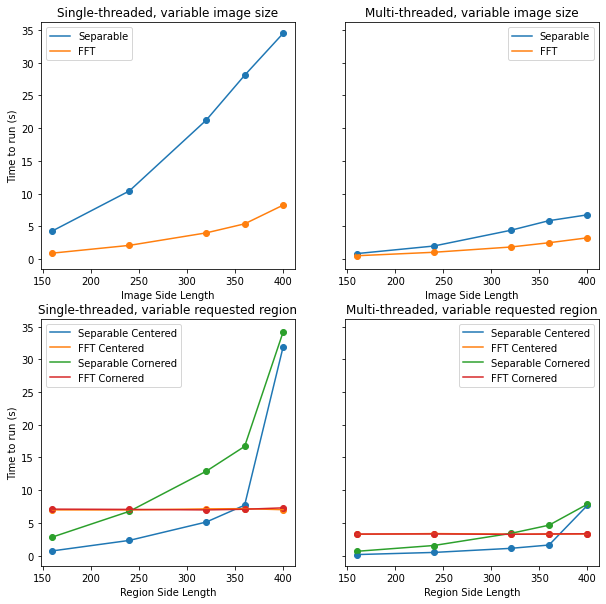

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), sharey=True)
region_lengths = [ratios[idx] * image_size[0] for idx, _ in enumerate(ratios)]

for threading_type in range(2):
    for image_or_region in range(2):
        ax = axs[image_or_region, threading_type]

        if image_or_region == 1:  # Variable region has different index alignments
            for alignment_idx in [
                REGION.SUBREGION_CENTERED,
                REGION.SUBREGION_CORNERED,
            ]:
                for backend_type in [SMOOTHING.SEPARABLE, SMOOTHING.FFT]:
                    ax.plot(
                        region_lengths,
                        data[
                            threading_type, alignment_idx.value, backend_type.value, :
                        ],
                    )
                    ax.scatter(
                        region_lengths,
                        data[
                            threading_type, alignment_idx.value, backend_type.value, :
                        ],
                    )
            ax.legend(
                [
                    "Separable Centered",
                    "FFT Centered",
                    "Separable Cornered",
                    "FFT Cornered",
                ]
            )
        else:
            for backend_type in [SMOOTHING.SEPARABLE, SMOOTHING.FFT]:
                ax.plot(
                    region_lengths,
                    data[threading_type, REGION.LARGEST.value, backend_type.value, :],
                )
                ax.scatter(
                    region_lengths,
                    data[threading_type, REGION.LARGEST.value, backend_type.value, :],
                )
                ax.legend(["Separable", "FFT"])

        ax.set_xlabel(
            "Image Side Length" if image_or_region == 0 else "Region Side Length"
        )

axs[0, 0].set_title("Single-threaded, variable image size")
axs[0, 1].set_title("Multi-threaded, variable image size")
axs[1, 0].set_title("Single-threaded, variable requested region")
axs[1, 1].set_title("Multi-threaded, variable requested region")

for ax in axs[:, 0]:
    ax.set_ylabel("Time to run (s)")

plt.show()


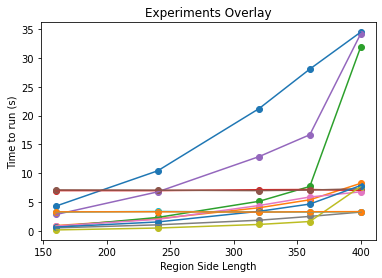

In [10]:
# Overlay all experiments to visually compare trends
n_experiments = 1
for val in data.shape[:-1]:
    n_experiments *= val
data_reshaped = np.reshape(data, [n_experiments, data.shape[-1]])

for experiment in range(n_experiments):
    plt.plot(region_lengths, data_reshaped[experiment, :])
    plt.scatter(region_lengths, data_reshaped[experiment, :])

plt.title("Experiments Overlay")
plt.xlabel("Image Side Length" if image_or_region == 0 else "Region Side Length")
plt.ylabel("Time to run (s)")
plt.show()
